02で前処理をしたデータの読み込みとモデルの学習を行うためのnotebookです。  
ここで作成したモデルは **src/models/** フォルダに格納して推論の際に使うようにして下さい。

## 必要なライブラリのimport

In [20]:
import warnings
import time
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import optuna
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, StratifiedKFold


warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', 500)

In [8]:
# データの読み込み
path_train_prepro = '../../../../data/processed/train_processed_0618.csv'
train = pd.read_csv(path_train_prepro)

# 目的変数と説明変数の作成
target = train['target']
del train['target']

In [3]:
# lightgbmのパラメータ
param = {'num_leaves': 111,
         'min_data_in_leaf': 149, 
         'objective':'regression',
         'max_depth': 9,
         'learning_rate': 0.005,
         "boosting": "gbdt",
         "feature_fraction": 0.7522,
         "bagging_freq": 1,
         "bagging_fraction": 0.7083 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2634,
         "random_state": 133,
         "verbosity": -1}

In [21]:

def objective(trial):
    # 調整したいハイパーパラメータについて範囲を指定
    param = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': 'rmse',
        'max_depth': trial.suggest_int('max_depth', 5,20),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.001, 0.01),
        'n_estimators': 100000,
        'importance_type': 'gain',
        'num_leaves': trial.suggest_int('num_leaves', 100, 200),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 100,200),
        'min_sum_hessian_in_leaf': trial.suggest_int('min_sum_hessian_in_leaf', 5, 50),
        'lambda_l1': trial.suggest_uniform('lambda_l1', 0.,1.),
        'lambda_l2': trial.suggest_uniform('lambda_l2', 0.,1.),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 0, 10),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
        'random_seed': 26,
        "verbosity": -1
    }

    model = lgb.LGBMRegressor(**param)
    model.fit(x_train, y_train, eval_set=[(x_valid, y_valid)], eval_metric='rmse',)

    preds = model.predict_proba(x_valid)[:, 1]

    # クロスバリデーションを用いてrmseを計算
    scores = cross_val_score(model, x_train, y_train, cv=cv, scoring='rmse')
    mean_scores = np.mean(scores)


    # CVのRMSEの平均値を目的関数として返す
    return print("CV score: {:<8.5f}".format(mean_scores)) #np.mean(rmses)


In [41]:
def objective(trial):
    # 調整したいハイパーパラメータについて範囲を指定
    param = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': 'rmse',
        'max_depth': trial.suggest_int('max_depth', 5, 20),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.001, 0.01),
        'n_estimators': 100000,
        'importance_type': 'gain',
        'num_leaves': trial.suggest_int('num_leaves', 100, 200),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 100, 200),
        'min_sum_hessian_in_leaf': trial.suggest_int('min_sum_hessian_in_leaf', 5, 50),
        'lambda_l1': trial.suggest_uniform('lambda_l1', 0.0, 1.0),
        'lambda_l2': trial.suggest_uniform('lambda_l2', 0.0, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 0, 10),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
        'random_seed': 26,
        'verbosity': -1
    }

    rmses = []
    
    # KFoldのオブジェクトを生成
    kf = KFold(n_splits=5, shuffle=True, random_state=26) 

    # KFold CV
    for train_index, valid_index in kf.split(x_train):

        x_train_cv ,y_train_cv = x_train.iloc[train_index], y_train.iloc[train_index]
        x_valid_cv ,y_valid_cv = x_train.iloc[valid_index], y_train.iloc[valid_index]


        model = lgb.LGBMRegressor(**param)    

        model.fit(
            x_train_cv, 
            y_train_cv, 
            eval_set = [(x_train_cv, y_train_cv), (x_valid_cv, y_valid_cv)], 
            #early_stopping_rounds = 100, 
            categorical_feature = categorical_feats, 
            #verbose = 500, 
        )

        y_pred_valid = model.predict(x_valid_cv, num_iteration=model.best_iteration_)       

        # RMSEを算出
        temp_rmse_valid = np.sqrt(mean_squared_error(y_valid_cv, y_pred_valid))

        # RMSEをリストにappend
        rmses.append(temp_rmse_valid)

    # CVのRMSEの平均値を目的関数として返す
    return np.mean(rmses)

In [26]:
x_train, x_valid, y_train, y_valid = train_test_split(train[features],target, test_size=0.2, random_state=26)

In [10]:
# 特徴量の情報
features = [c for c in train.columns if c not in ['card_id', 'first_active_month','hist_date_min','hist_date_max','new_date_min','new_date_max',]]
#categorical_feats = ['feature_1','feature_2', 'feature_3','hist_merchant_category_nu','hist_merchant_category_mode','hist_city_nu','hist_city_mode','hist_state_nu','hist_state_mode','hist_category_1_mod','hist_category_2_mod','hist_category_3_mod','new_merchant_category_nu','new_merchant_category_mode','new_city_nu','new_city_mode','new_state_nu','new_state_mode','new_category_1_mod','new_category_2_mod','new_category_3_mod']
categorical_feats = ['feature_1','feature_2', 'feature_3','hist_merchant_category_nu','hist_merchant_category_mode','hist_city_nu','hist_city_mode','hist_state_nu','hist_state_mode','hist_category_1_mod','hist_category_2_mod','hist_category_3_mod']

In [33]:
features

['feature_1',
 'feature_2',
 'feature_3',
 'elapsed_time',
 'hist_frequency',
 'hist_amount_total',
 'hist_amount_mean',
 'hist_merchant_category_nu',
 'hist_merchant_category_mode',
 'hist_city_nu',
 'hist_city_mode',
 'hist_state_nu',
 'hist_state_mode',
 'hist_installments_mean',
 'hist_installments_max',
 'hist_installments_min',
 'hist_month_lag_mean',
 'hist_month_lag_max',
 'hist_month_lag_min',
 'hist_category_1_mod',
 'hist_category_2_mod',
 'hist_category_3_mod',
 'hist_ratio_No',
 'hist_ratio_Yes',
 'hist_count_No',
 'hist_count_Yes',
 'hist_duration']

In [42]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

best_params = study.best_trial.params
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2024-06-19 11:37:55,319] A new study created in memory with name: no-name-95a92751-6137-492f-a557-e4d33c7efe31
[W 2024-06-19 11:41:36,496] Trial 0 failed with parameters: {'max_depth': 12, 'learning_rate': 0.004607900489442396, 'num_leaves': 190, 'min_data_in_leaf': 113, 'min_sum_hessian_in_leaf': 23, 'lambda_l1': 0.9406966894470519, 'lambda_l2': 0.07861258418841222, 'bagging_fraction': 0.504671179023334, 'bagging_freq': 1, 'feature_fraction': 0.18101080801027733} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "C:\Users\kakeru.oshikiri.bt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\kakeru.oshikiri.bt\AppData\Local\Temp\ipykernel_11444\3450705265.py", line 37, in objective
    model.fit(
  File "C:\Users\kakeru.oshikiri.bt\

KeyboardInterrupt: 

In [36]:
# データをKFoldで5分割して学習
folds = KFold(n_splits=5, shuffle=True, random_state=26)
oof = np.zeros(len(train))
predictions = np.zeros(len(target))
start = time.time()
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features],
                           label=target.iloc[trn_idx],
                           categorical_feature=categorical_feats
                          )
    val_data = lgb.Dataset(train.iloc[val_idx][features],
                           label=target.iloc[val_idx],
                           categorical_feature=categorical_feats
                          )

    num_round = 10000
    clf = lgb.train(
                    params = param,
                    train_set=trn_data,
                    num_boost_round=num_round,
                    valid_sets=[val_data],
                    callbacks=[lgb.early_stopping(stopping_rounds=200),
                               lgb.log_evaluation(100)],
                    )

    #clf = lgb.train(param, trn_data)

    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    # モデルを保存
    with open(f'../src/models/lgb_0618/model_fold_{fold_}.pkl', 'wb') as f:
        pickle.dump(clf, f)

print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))

fold n°0
Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 3.78192
[200]	valid_0's rmse: 3.76673
[300]	valid_0's rmse: 3.76048
[400]	valid_0's rmse: 3.75814
[500]	valid_0's rmse: 3.75764
[600]	valid_0's rmse: 3.75766
[700]	valid_0's rmse: 3.75845
Early stopping, best iteration is:
[542]	valid_0's rmse: 3.75734
fold n°1
Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 3.81096
[200]	valid_0's rmse: 3.79123
[300]	valid_0's rmse: 3.78271
[400]	valid_0's rmse: 3.77887
[500]	valid_0's rmse: 3.7768
[600]	valid_0's rmse: 3.77594
[700]	valid_0's rmse: 3.77585
[800]	valid_0's rmse: 3.77584
Early stopping, best iteration is:
[611]	valid_0's rmse: 3.77566
fold n°2
Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 3.8444
[200]	valid_0's rmse: 3.82745
[300]	valid_0's rmse: 3.81958
[400]	valid_0's rmse: 3.81603
[500]	valid_0's rmse: 3.81456
[600]	valid_0's rmse: 3.81417
[700]	valid_0's rmse: 3.81452

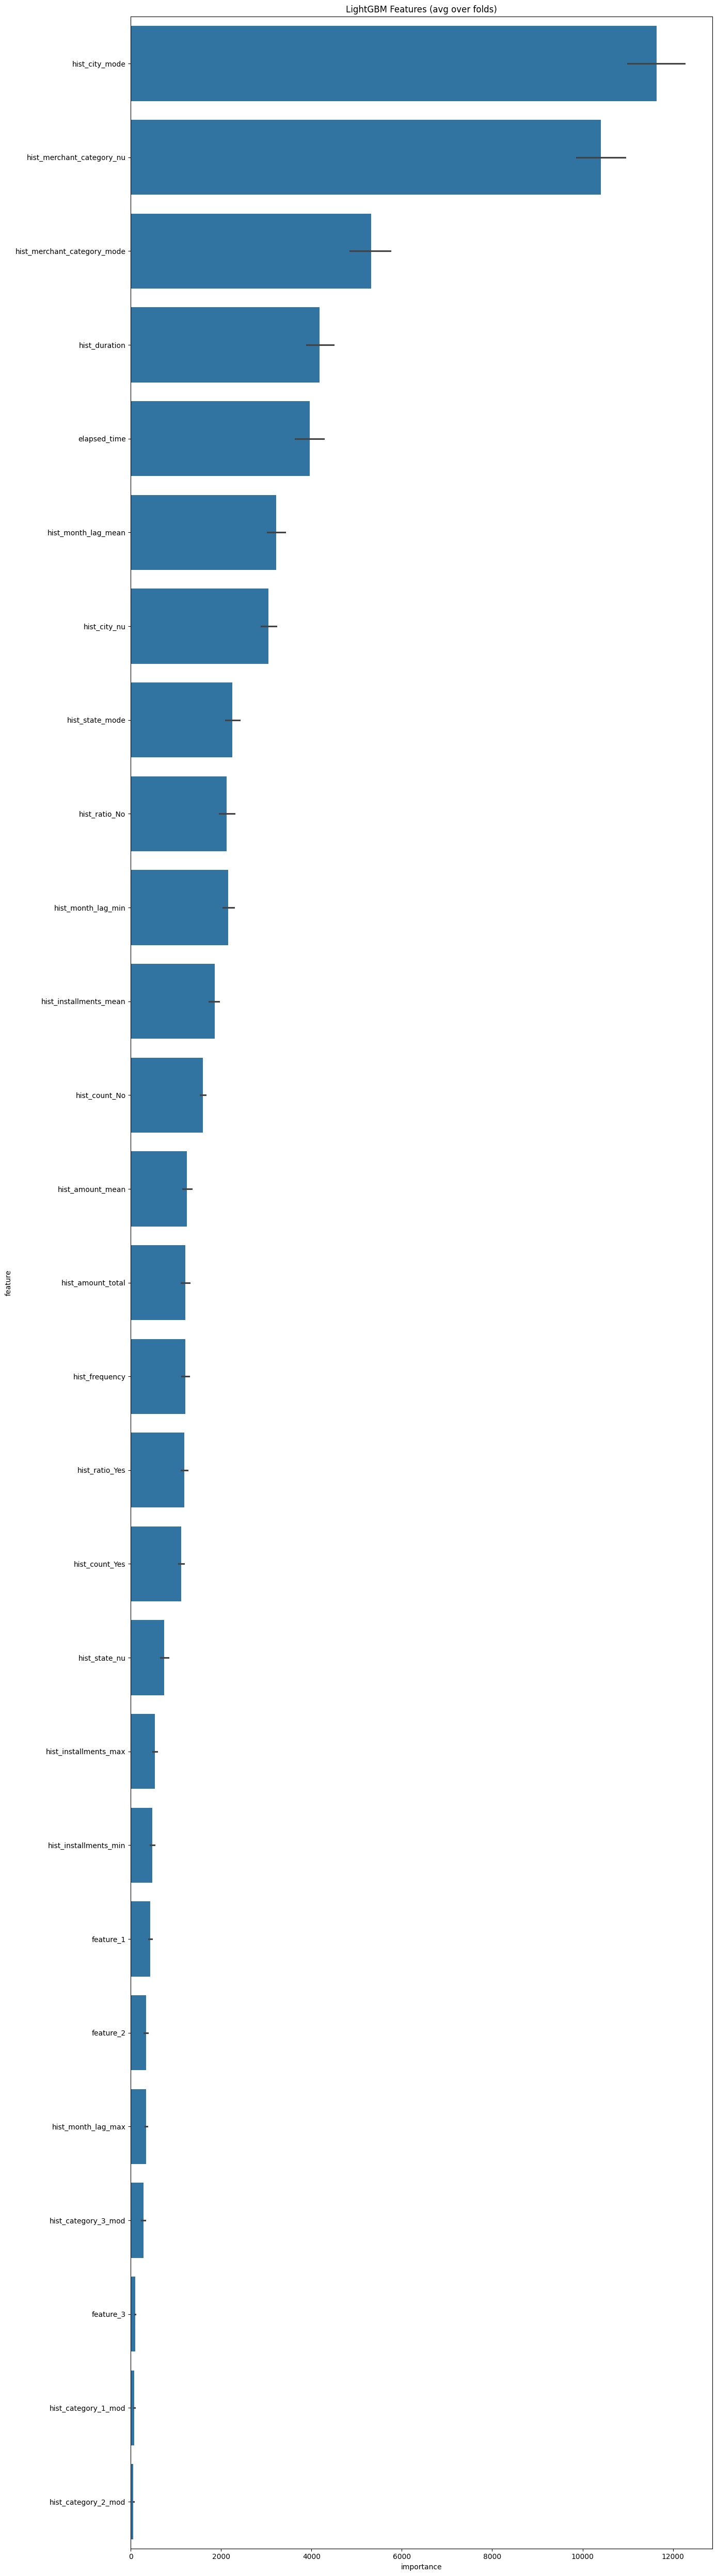

In [37]:
# 特徴量重要度の可視化

cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,50))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
# plt.savefig('lgbm_importances.png')